# Академия Аналитиков Авито

# Эконометрика

Общий план курса:
- Повторение теории вероятности и математической статистики
- Классическая линейная регрессия
- Множественная регрессия
- Метрики качества регрессии и проверка гипотез, связанных с ней
- Нарушение предпосылок теоремы Гаусса-Маркова
- Модели бинарного выбора
- **Временные ряды**

# Занятие №10

На предыдущем занятии мы:

- Изучили разные типы ошибок прогноза

![image.png](https://media.makeameme.org/created/so-youre-telling-5b9b3d.jpg)

- Познакомились с моделью FBProphet

![image.png](https://miro.medium.com/max/1154/1*jxk0QhfTSMN2xk0U7G_kbw.jpeg)

# Повторение

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.datasets import longley
from statsmodels.formula.api import ols

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# инициализируем plotly
init_notebook_mode(connected = True)

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
# Функция для получения данных 'mdape', 'mape', 'mtape' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(fp_model):
    fp_df_cv = cross_validation(fp_model, initial='730.25 days', period='28 days', horizon = '28 days', parallel="processes")
    res = performance_metrics(fp_df_cv,rolling_window = 1)
    mape = np.mean(abs(fp_df_cv['y'] - fp_df_cv['yhat'])/ (fp_df_cv['y']+1))
    res['mape']=mape
    return res

## План занятия: 
- Добавление нового предиктора
- Seasonal ARIMA (SARIMA)
- Диагностика модели
    - Diebold-Mariano test
    - Model encompassing
    - Model combinations

#### Данные с прошлого занятия

Для нашего примера возьмем данные о продажах Walmart, крупнейшей в мире компании по выручке, для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview)

Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают в себя детализацию о товаре - отдел, категорию и информацию о точке продаж. Кроме того, есть поясняющие переменные, такие как день недели и особые события. Вместе этот набор данных можно использовать для повышения точности прогнозов.

Для нас это замечательный пример реальной потребности бизнеса в прогнозах продаж. Для себя мы ее немного упростим и займемся только **предсказанием количества проданных товаров в одном штате в одной категории в целом** (не углубляясь до торговых точек)

In [3]:
# Получение и обработка исходных данных.

# Тренировочный датафрейм с проданными айтемами
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

# Будем работать не с каждой конкретной точкой, а с продажами в каждом конкретном штате по категориям
stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)

In [4]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [5]:
# Присоединение дат к id
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [6]:
# Приведение к нужному для fbprophet виду
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [7]:
# Выделим только данные по Калифорнии
ca_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'CA', ['ds', 'cat_id', 'y']].copy()

# Посмотрим на распрделение продаж по категориям
plotly_df(ca_data.pivot(index='ds', columns='cat_id', values='y'), title = 'CA items sold')

In [8]:
# Для нашего примера поработаем только с категорией 'HOUSEHOLD'

data = ca_data.loc[(ca_data.cat_id == 'HOUSEHOLD')&(ca_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)

data_evaluation = ca_data.loc[(ca_data.cat_id == 'HOUSEHOLD'),['ds', 'y']].copy().reset_index(drop = True)


#### Календарь с праздниками

In [9]:
import holidays

us_ca_holidays = holidays.UnitedStates(state='CA', years = [2011,2012,2013,2014,2015,2016,2017,2018], \
                                       observed = False)

holiday_df = pd.DataFrame.from_dict(us_ca_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

,holiday,ds,lower_window,upper_window
0,New Year's Day,2011-01-01,-1,1
1,Martin Luther King Jr. Day,2011-01-17,-1,1
2,Valentine's Day,2011-02-14,-1,1
3,Washington's Birthday,2011-02-21,-1,1
4,César Chávez Day,2011-03-31,-1,1


#### Лучшая модель с прошлого занятия 

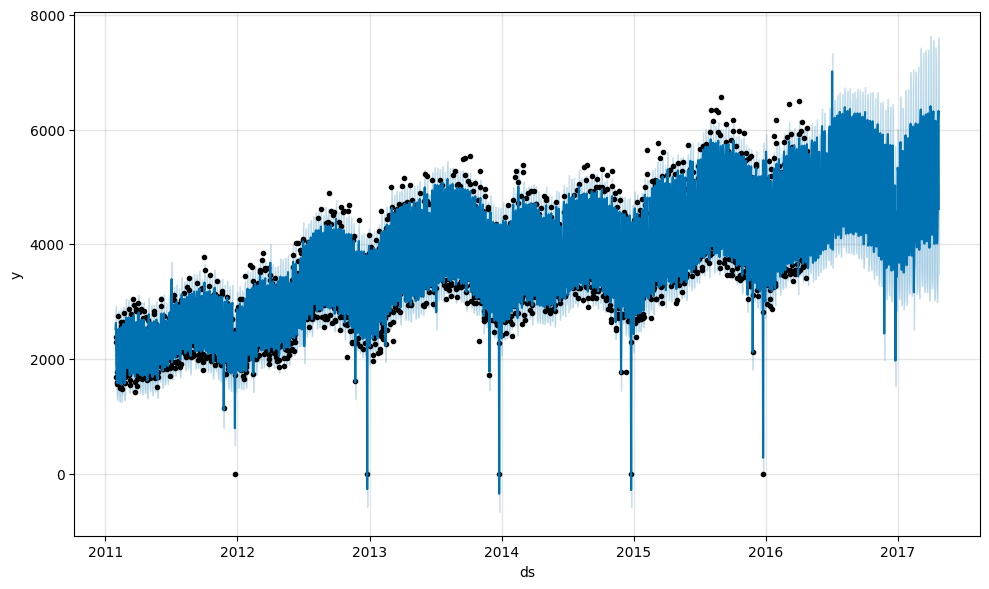

In [10]:
# Посмотрим, что будет при учете праздников

m_7 = fp.Prophet(
    changepoint_prior_scale=0.25,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df)

m_7.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_7.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_7.fit(data)

future = m_7.make_future_dataframe(periods=365)

forecast = m_7.predict(future)
fig7 = m_7.plot(forecast)

In [11]:
%%time

m7_metrics = perf_metrics_28d(m_7)
m7_metrics

KeyboardInterrupt: 

**Рассмотрим еще один вид ошибки:**

$$\text{ Mean absolute percentage error: }  MAPE = mean(\frac{|y_t - \hat{y_t}|}{y_t})$$

$$\text{ Symmetric mean absolute percentage error: }  SMAPE = 2mean(\frac{200*|y_t - \hat{y_t}|}{y_t+ \hat{y_t}})$$


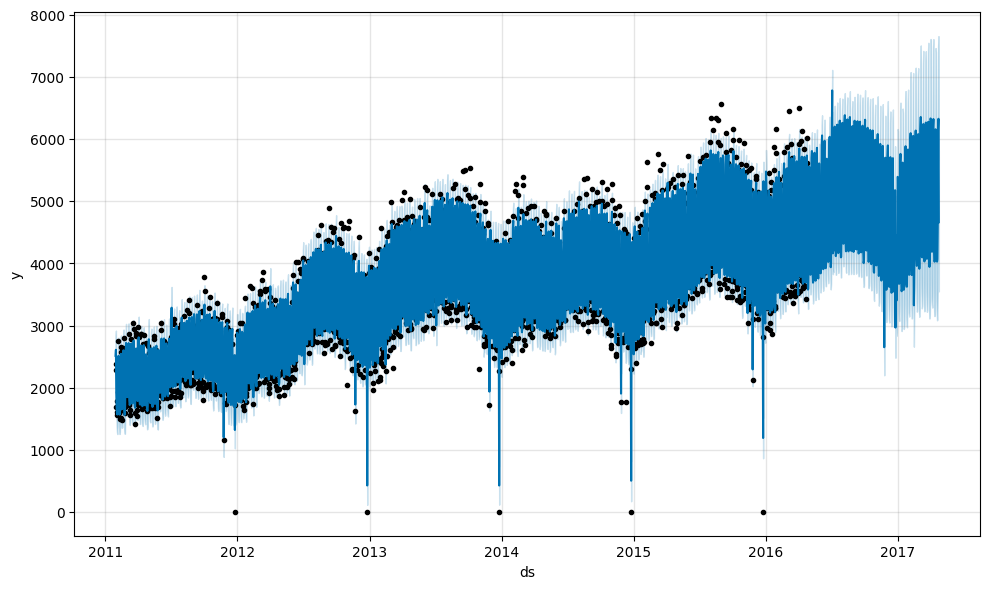

In [12]:
# попробуем скорректировать влияние праздников

m_8 = fp.Prophet(
    changepoint_prior_scale=0.25,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df,
    holidays_prior_scale = 0.05)

m_8.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_8.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')


m_8.fit(data)

future = m_8.make_future_dataframe(periods=365)

forecast = m_8.predict(future)
fig7 = m_8.plot(forecast)

In [ ]:
%%time

m8_metrics = perf_metrics_28d(m_8)
m8_metrics

### Добавление нового предиктора

Дополнительные регрессоры могут быть добавлены к линейной части модели с использованием add_regressor метода. 

Столбец со значением регрессора должен присутствовать как во фреймах данных, так и в прогнозе. 

На графике компонентов этот эффект будет отображаться на графике extra_regressors

**Попробуем добавить дополнительный регрессор 10 июня 2012 (там можно наблюдать "ступеньку" в данных)**



In [13]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds'), title = 'CA items sold in household category')

In [14]:
# Просто проставляем 1, если данные после начала запуска производства в РФ и 0 в иных случаях

def period_after(ds):
    if ds >= datetime.date(2012,6,9):
        return 1
    else:
        return 0

In [15]:
# Добавляем и в обучающие данные и в future значение дополнительного регрессора 

data['after_something'] = data['ds'].apply(period_after)

/tmp/ipykernel_7574/4280352608.py:4: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



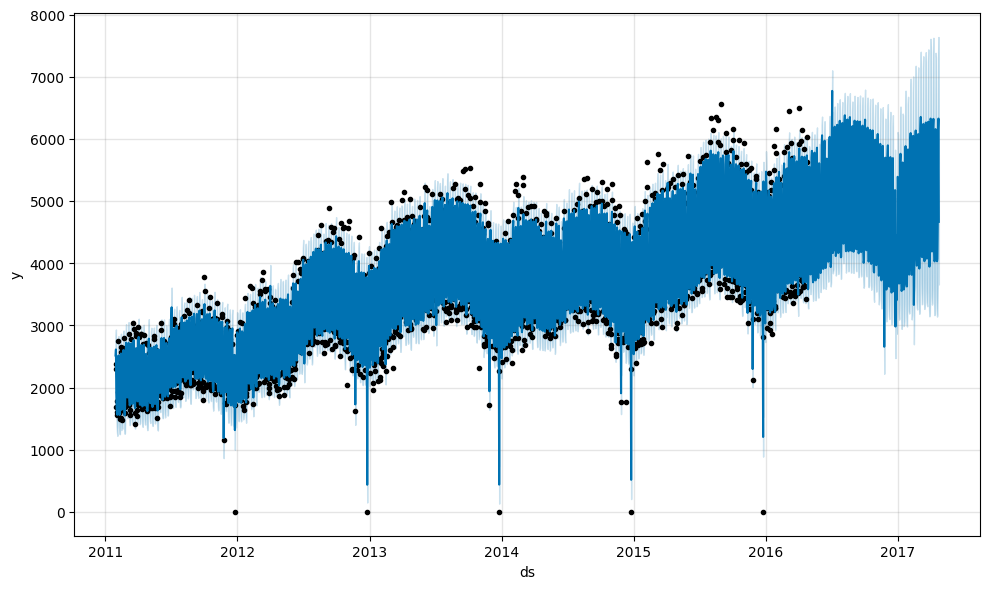

In [16]:
# попробуем скорректировать влияние праздников

m_9 = fp.Prophet(
    changepoint_prior_scale=0.25,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df,
    holidays_prior_scale = 0.05)

m_9.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_9.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')

# Добавляем регрессор до fit
m_9.add_regressor('after_something', mode='multiplicative')

m_9.fit(data)

future = m_9.make_future_dataframe(periods=365)
future['after_something'] = future['ds'].apply(period_after)

forecast = m_9.predict(future)
figure = m_9.plot(forecast)

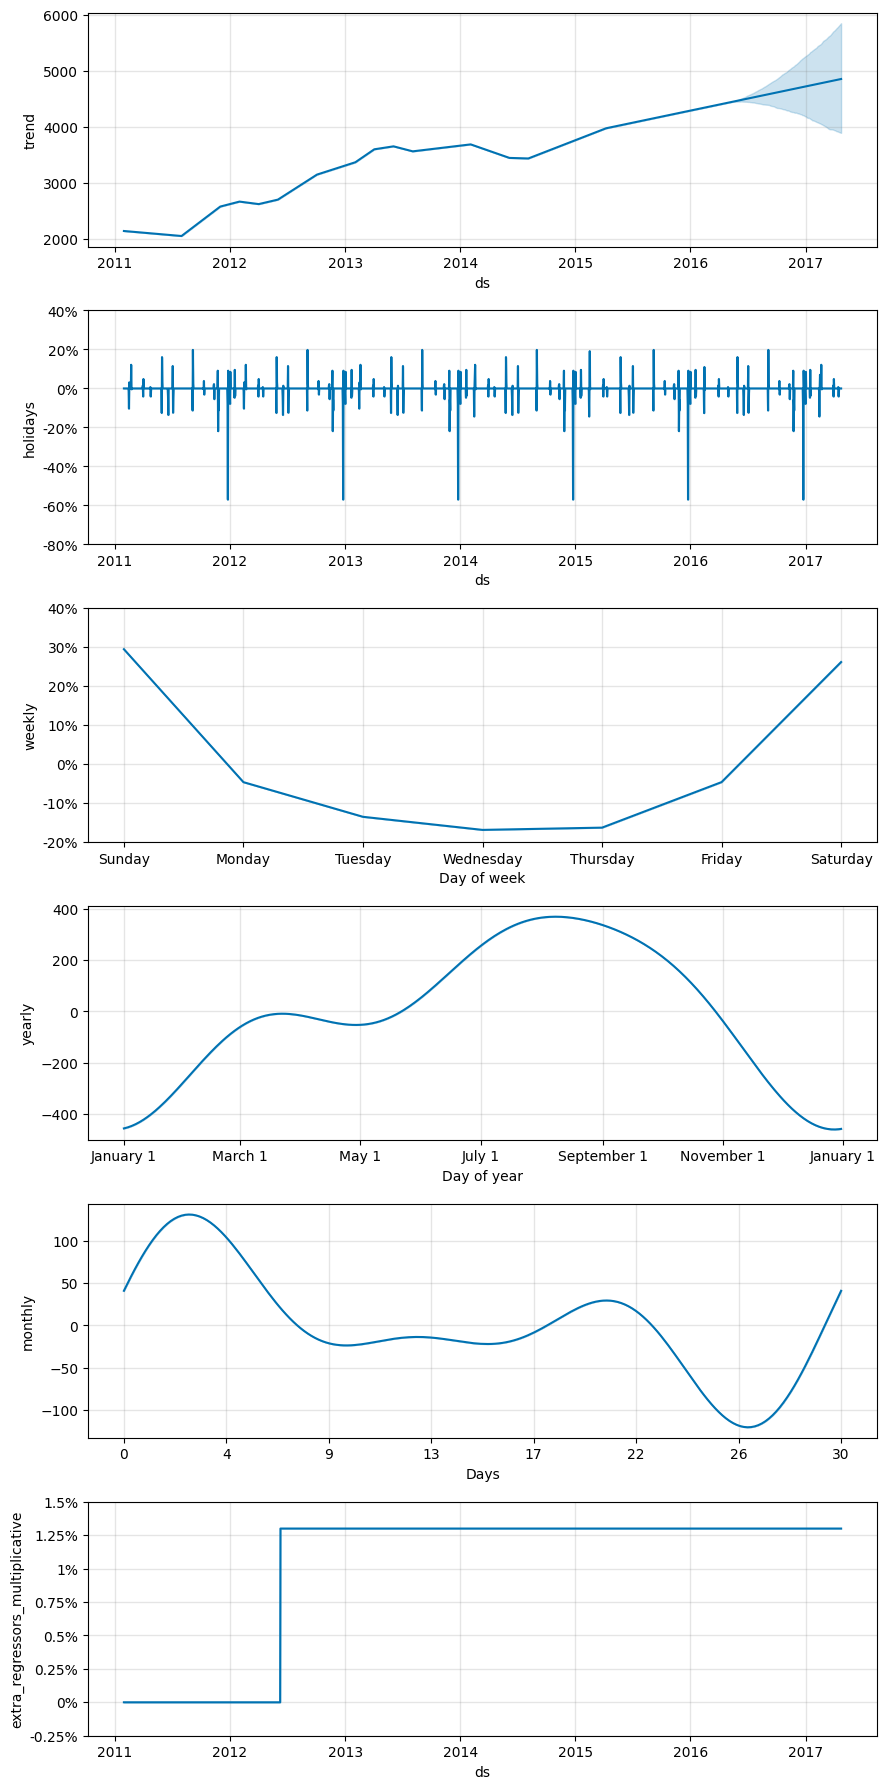

In [17]:
fig_components = m_9.plot_components(forecast)


In [ ]:
%%time

m9_metrics = perf_metrics_28d(m_9)
m9_metrics

In [ ]:
# Сравним с показателями модели с sesonal_mode = 'multiplicative'
m8_metrics


**Попробуйте добавить дополнительный регрессор SNAP.** SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program). Информацию про SNAP можно найти в таблице `calendar`



In [42]:
calendar

,date,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
data = data.merge(calendar[['date','snap_CA']], how = 'left', left_on='ds',
                                                      right_on = 'date')

/tmp/ipykernel_7574/4280352608.py:4: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



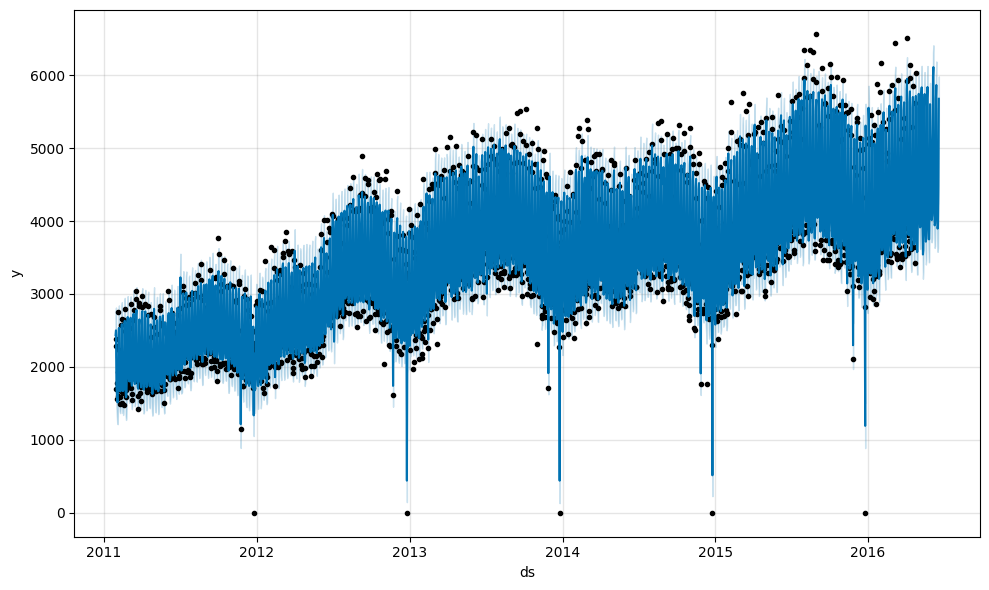

In [43]:
# попробуем скорректировать влияние праздников

m_10 = fp.Prophet(
    changepoint_prior_scale=0.25,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df,
    holidays_prior_scale = 0.05)

m_10.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_10.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')

# Добавляем регрессор до fit
m_10.add_regressor('after_something', mode='multiplicative')
m_10.add_regressor('snap_CA', mode='multiplicative')

m_10.fit(data)

future = m_10.make_future_dataframe(periods=55)
future['after_something'] = future['ds'].apply(period_after)
future['snap_CA'] = calendar['snap_CA']
future['snap_CA'].fillna(0, inplace=True)

forecast = m_10.predict(future)
figure = m_10.plot(forecast)

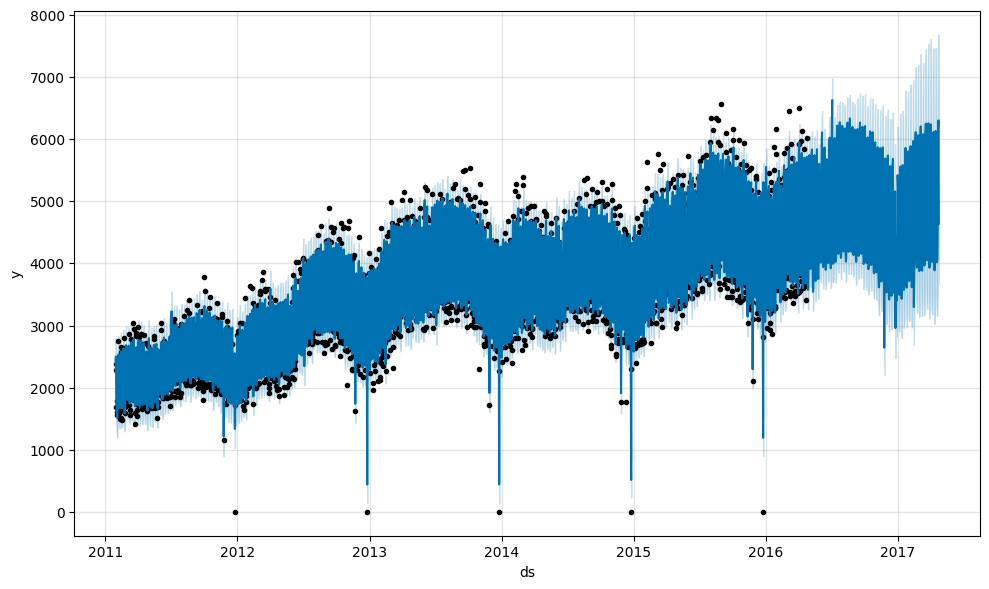

In [41]:
forecast = m_10.predict(future)
figure = m_10.plot(forecast)

### Seasonal ARIMA

Seasonal ARIMA - модель очень похожая на классическую ARIMA, за исключением того, что SARIMA позволяет так же моделировать и сезонные компоненты ARIMA. 

![image.png](https://miro.medium.com/max/1400/1*yxe5Sf5JSAROq-UVgMLtmA.png)

Формула: 

![image.png](https://miro.medium.com/max/1400/1*0A5Y8uQlGcVe6QpOGonZpw.png)



Для начала попробуем смоделировать обычную ARIMA на наших данных 

In [44]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds')[['y']], title = 'CA items sold in household category')

Figure(640x480)
Figure(640x480)


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



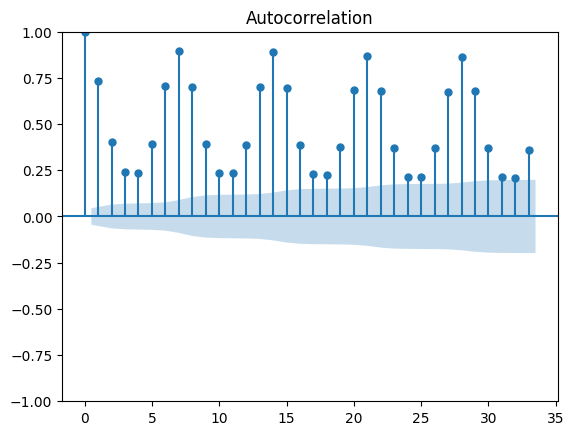

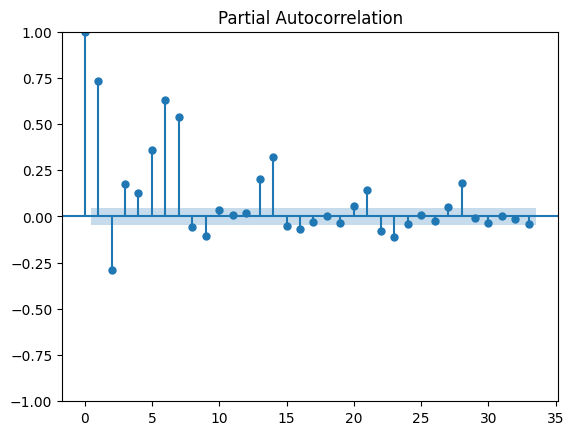

In [45]:
print(plot_acf(data.y))
print(plot_pacf(data.y))

In [46]:
adf_test(data.y)

Results of Dickey-Fuller Test:
Test Statistic                   -1.593227
p-value                           0.486995
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64 
 Null Hypothesis: The series has a unit root.


In [47]:
kpss_test(data.y)

Results of KPSS Test:
Test Statistic            6.47305
p-value                   0.01000
Lags Used                23.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64 
 Null Hypothesis: The process is trend stationary.


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [48]:
data['y_diff'] = data.y.diff().dropna()

In [49]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds')[['y_diff']], title = 'CA items sold in household category')

Figure(640x480)
Figure(640x480)


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



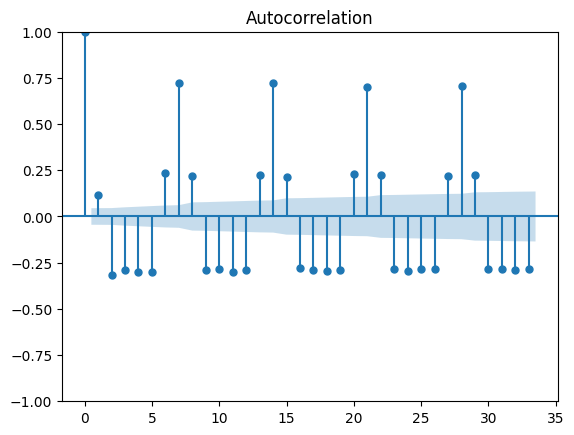

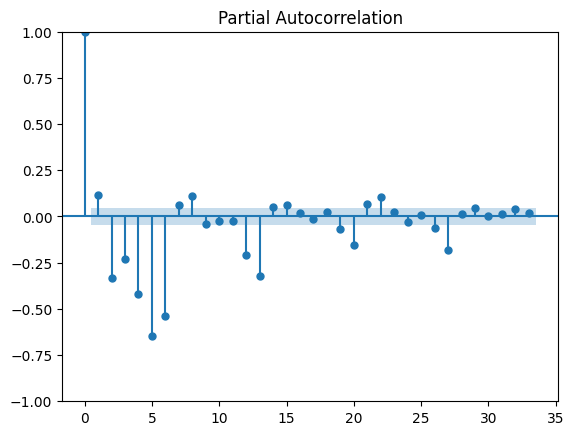

In [50]:
print(plot_acf(data['y_diff'].dropna()))
print(plot_pacf(data['y_diff'].dropna()))

In [51]:
print(adf_test(data['y_diff'].dropna()),'\n')
print(kpss_test(data['y_diff'].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -1.294395e+01
p-value                        3.487419e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64 
 Null Hypothesis: The series has a unit root.
None 

Results of KPSS Test:
Test Statistic            0.023093
p-value                   0.100000
Lags Used                51.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.
None


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [52]:
# # С помощью автоматического перебора, подберем спецификацию ARIMA

# import pmdarima as pm

# # Create auto_arima model
# model1 = pm.auto_arima(data.y, #time series
#                       d=1, # difference order
#                       max_p=6, # max value of p to test 
#                       max_q=6, # max value of p to test
#                       information_criterion='aic', # used to select best mode
#                       trace=True, # prints the information_criterion for each model it fits
#                       error_action='ignore', # ignore orders that don't work
#                       stepwise=True, # apply an intelligent order search
#                       suppress_warnings=True) 

# # Print model summary
# print(model1.summary())

In [54]:
best_arima = ARIMA(data.y, order=(6, 1, 6))
best_arima =  best_arima.fit()
best_arima.summary()

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid.plot()

In [ ]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

Кажется, что обычная ARIMA не справляется с моделлированием, даже если мы включим много AR лагов (6).

**А что если попробовать SARIMA?**

In [ ]:
data['y_diff_7'] = data.y.diff().diff(7).dropna()
data = data.dropna()

In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds')[['y_diff_7']])
print(plot_acf(data[['y_diff_7']]))
print(plot_pacf(data.set_index('ds')[['y_diff_7']]))

In [ ]:
print(adf_test(data.set_index('ds')[['y_diff_7']]),'\n')
print(kpss_test(data.set_index('ds')[['y_diff_7']]))

In [ ]:
# # С помощью автоматического перебора, подберем спецификацию ARIMA

# import pmdarima as pm

# # Create auto_arima model
# model2 = pm.auto_arima(data.y, #time series
#                       d=1, # difference order
#                       D=1, # seasonal difference order
#                       max_p = 2,
#                       max_q = 2,                       
#                       information_criterion='aic', # used to select best mode
#                       m=7, # number of periods in each season
#                       max_P = 5,
#                       start_Q = 0,
#                       max_Q=0,
#                       seasonal=True, # enable sasonal component
#                       trace=True, # prints the information_criterion for each model it fits
#                       error_action='ignore', # ignore orders that don't work
#                       stepwise=True, # apply an intelligent order search
#                       suppress_warnings=True) 

# # Print model summary
# print(model2.summary())

# # result = ARIMA(5,1,0)(2,0,0)[7]

In [ ]:
%%time

best_arima = ARIMA(data.y, order=(1, 1, 1), seasonal_order=(7,1,0,7))
best_arima =  best_arima.fit()
best_arima.summary()

In [ ]:
max(data_evaluation['ds'])-max(data['ds'])

In [ ]:
forecast_sarima = best_arima.predict()
forecast_sarima


forecast_test_sarima = best_arima.forecast(28)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid.plot()

In [ ]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

<span style="color:green">**Ответьте на вопросы:**</span>

- Какая спецификация SARIMA у модели для данных о продажах категории FOODS магазина в Техасе?

In [9]:
# Для нашего примера поработаем только с категорией 'HOUSEHOLD'

# Выделим только данные по Калифорнии
tx_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'TX', ['ds', 'cat_id', 'y']].copy()

# Посмотрим на распрделение продаж по категориям
plotly_df(tx_data.pivot(index='ds', columns='cat_id', values='y'), title = 'TX items sold')

data_tx = ca_data.loc[(ca_data.cat_id == 'FOODS')&(ca_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)

data_evaluation_tx = ca_data.loc[(ca_data.cat_id == 'FOODS'),['ds', 'y']].copy().reset_index(drop = True)

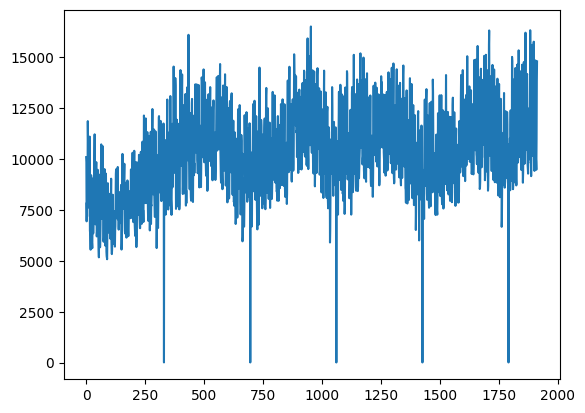

In [10]:
plt.plot(data_tx['y'].values);

In [12]:
import pmdarima as pm

In [ ]:
model2 = pm.auto_arima(data_tx.y, #time series
                      d=1, # difference order
                      D=1, # seasonal difference order
                      min_p = 1,
                      min_q = 0,
                      max_p = 2,
                      max_q = 2,                       
                      information_criterion='aic', # used to select best mode
                      m=7, # number of periods in each season
                      max_P = 5,
                      start_Q = 0,
                      max_Q=1,
                      seasonal=True, # enable sasonal component
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model2.summary())

# result = ARIMA(5,1,0)(2,0,0)[7]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,0)[7]             : AIC=inf, Time=12.56 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=33229.363, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=32523.511, Time=2.30 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.52 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=32979.116, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=32351.355, Time=5.59 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=32232.122, Time=11.82 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=32178.665, Time=24.24 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=32146.929, Time=40.29 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=63.39 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=68.13 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=32389.153, Time=9.10 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=32044.478, Time=43.77 sec


In [ ]:
best_arima = ARIMA(data_tx.y, order=(6, 1, 6))
best_arima =  best_arima.fit()
best_arima.summary()

### Выбор модели. Diebold-Mariano test.

Допустим есть 2 модели: модель А и модель B. Тогда пусть условная разница ошибок моделей будет:

$$e^A_t = y_t - y^A_t$$
$$e^B_t = y_t - y^B_t$$
$$d_t = (e^A_t)^2 - (e^B_t)^2$$


Интуитивно, если модели одинаково хороши (или плохи), то $d_t$ будет около нуля. 

Однако, если же модель A лучше модели B, тогда $E(d_t)<0$

Поэтому мы тестируем гипотезу: $H_0: E(d_t)=0$ против $H_a: E(d_t) \neq 0$

Ограничения теста:
 - модели не должны быть вложенными относительно друг друга 
 - модели должны быть линейны

In [ ]:
# попробуем скорректировать влияние праздников

m_6 = fp.Prophet(
    changepoint_prior_scale=0.25,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_6.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')

m_6.fit(data)

future = m_6.make_future_dataframe(periods=28)

forecast_season_fp = m_6.predict(future)
figure = m_6.plot(forecast_season_fp)

In [ ]:
forecast_season_fp['ds'] = forecast_season_fp['ds'].dt.date
data_w_error = data.merge(forecast_season_fp, how='left', on='ds')[['ds','y','yhat']]
resid_prophet = (data_w_error.y-data_w_error.yhat).dropna()

resid_sarima = best_arima.resid

dt = ((resid_prophet)**2-(resid_sarima)**2)


In [ ]:
from scipy import stats
stats.ttest_1samp(dt, popmean=0, alternative='less')

<span style="color:green">**Ответьте на вопросы:**</span>

- Проверьте прогноз SARIMA относительно FBProphet для ваших данных Техаса. Можете использовать спецификацию, выбранную для модели калифорнии.  

### Вложенность прогнозов

*Прогноз B вложен в прогноз A, если прогноз А использует всю релевантную информацию, которую использует прогноз B (или даже больше).*

Если же ни один из прогнозов не вложен друг в друга, значит, вероятно, комбинация этих прогнозов будет лучше, чем каждый из прогнозов по отдельности. 

Проверка на вложенность:

- оцениваем простую линейную регрессию: $Y_t = \beta_A*\hat{Y^A_t}+\beta_B*\hat{Y^B_t}+e_t$
- тестируем по очереди две гипотезы: 
 - $H^A_0: \beta_A = 1 \space\&\space \beta_B =0$ vs $H^A_1: \beta_B \neq 1 \space\&\space \beta_A \neq 0$
 - $H^B_0: \beta_B = 0 \space\&\space \beta_A = 1$ vs $H^A_1: \beta_B \neq 0 \space\&\space \beta_A \neq 1$ 
- если $H^A_0$ не отвергается, значит прогноз B вложен в прогноз А. То есть достаточно использовать только прогноз А. 
- если обе гипотезы отвергаются, значит ни один из прогнозов не вложен друг в друга. 

In [ ]:
# baseline model

m = fp.Prophet()

m.fit(data)

future = m.make_future_dataframe(periods=28)

forecast = m.predict(future)
forecast_base = forecast[['ds','yhat']]
forecast_base.columns=['ds', 'yhat_base']
forecast_base['ds'] = forecast_base['ds'].dt.date



In [ ]:
forecast_base

In [ ]:
data_test = data.merge(forecast_season_fp, on ='ds',how ='left').merge(forecast_base, on ='ds',how ='left')

data_test['yhat_sarima']=forecast_sarima

data_test = data_test[['ds','y','yhat','yhat_base','yhat_sarima']]
data_test.columns = ['ds','y','yhat_best_prophet','yhat_base_prophet','yhat_sarima']


In [ ]:
data_test

In [ ]:
formula = 'y ~ yhat_best_prophet + yhat_sarima'
results = ols(formula, data_test).fit()
hypotheses = '(yhat_best_prophet = 0), (yhat_sarima = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

formula = 'y ~ yhat_best_prophet + yhat_sarima'
results = ols(formula, data_test).fit()
hypotheses = '(yhat_best_prophet = 1), (yhat_sarima = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

In [ ]:
formula = 'y ~ yhat_best_prophet + yhat_base_prophet'
results = ols(formula, data_test).fit()
hypotheses = '(yhat_best_prophet = 0), (yhat_base_prophet = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

formula = 'y ~ yhat_best_prophet + yhat_base_prophet'
results = ols(formula, data_test).fit()
hypotheses = '(yhat_best_prophet = 1), (yhat_base_prophet = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

### Model Combination

Комбинировать модели можно: 
- взвешивая их по ошибкам
- оценивая веса с помощью линейной регрессии 

In [ ]:
rmse_fbprophet = ((data_test['y']-data_test['yhat_best_prophet'])**2).sum()

rmse_sarima = ((data_test['y']-data_test['yhat_sarima'])**2).sum()

w_prophet = rmse_fbprophet/(rmse_fbprophet+rmse_sarima)
w_sarima = rmse_sarima/(rmse_fbprophet+rmse_sarima)
print('prophet weight: {}, sarima weight: {}'.format(w_prophet,w_sarima))

data_test['y_comb'] = data_test['yhat_best_prophet']* w_prophet + data_test['yhat_sarima']*w_sarima

data_test

In [ ]:
formula = 'y ~ yhat_best_prophet + yhat_sarima'
results = ols(formula, data_test).fit()
results.summary()